In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmasher as cmr

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from PIL import Image

import os
from pathlib import Path
import requests
from tqdm.notebook import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

ROOT = Path('../..').resolve()
results_dir = ROOT/'results/xSAGA-init'

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

#cosmology
c = FlatLambdaCDM(H0=70, Om0=0.3)


In [48]:
# sats after they've been crossmatched to hosts, in descending order of stellar mass
sats = pd.read_csv(results_dir/'sats_in_hosts.csv')

# SAGA-s2
saga_sats = pd.read_csv(ROOT/'data/saga_stage2_sats.csv')
saga_hosts = pd.read_csv(ROOT/'data/saga_stage2_hosts.csv', index_col='INTERNAL_HOSTID')

# More sanity checks on initial results

## Surface brightness and color vs magnitude (Mao+2020 Fig 6)

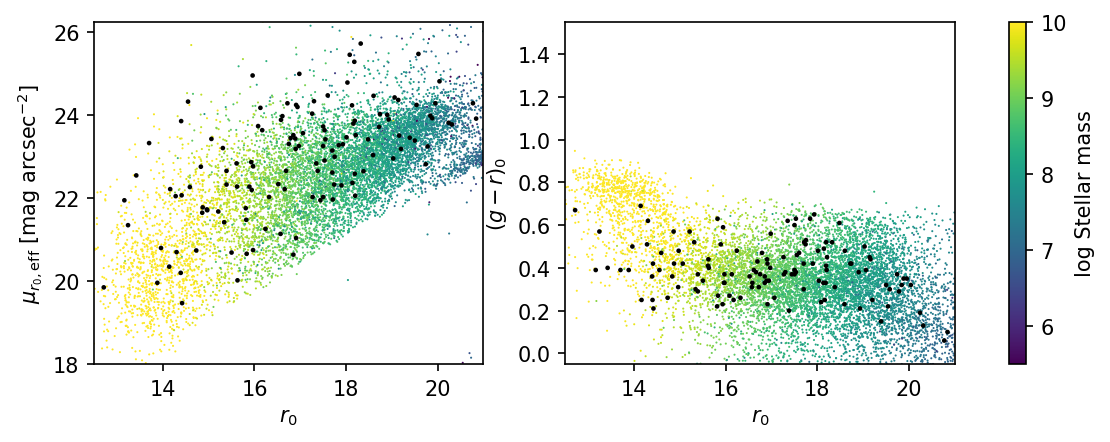

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

ax1.scatter(sats.r0, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(12.5, 21)
ax1.set_ylim(18, 26.25)
ax1.set_xlabel(r'$r_0$')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

sc = ax2.scatter(sats.r0, sats.g0-sats.r0, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.R, saga_sats.GR, s=5, c='k', edgecolor='none')
ax2.set_xlim(12.5, 21)
ax2.set_ylim(-0.05, 1.55)
ax2.set_xlabel('$r_0$')
ax2.set_ylabel(r'$(g-r)_0$')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2])
cb.set_label('log Stellar mass')



## Surface brightness vs physical radius and color (Mao+2020 Fig 9)

In [64]:
saga_sats['R_eff'] = np.sqrt(np.power(10, (saga_sats.MU_EFF - saga_sats.R) / 2.5) / (2*np.pi))
saga_sats['DIST'] = saga_hosts.loc[saga_sats.INTERNAL_HOSTID].DIST.values * 1000 # kpc
saga_sats['R_physical'] = (saga_sats.R_eff.values * u.arcsec).to(u.radian).value * saga_sats.DIST


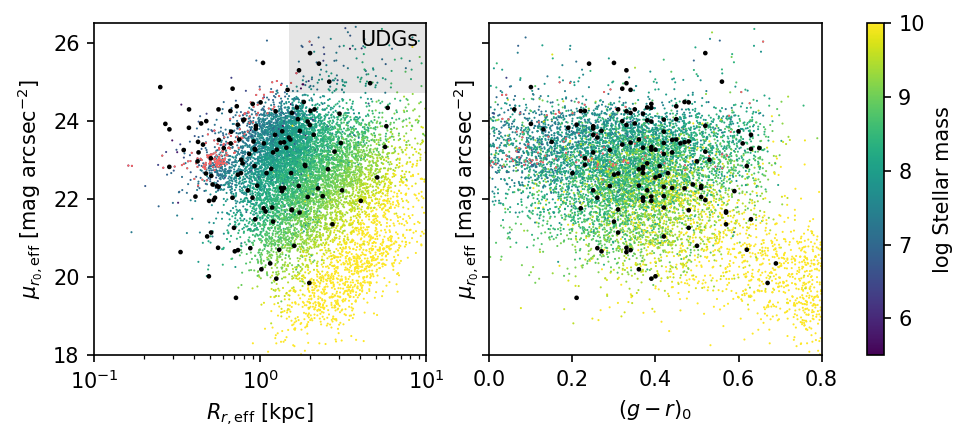

In [80]:
# Mao+2020 Fig 9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150, sharey=True)

ax1.scatter(sats.R_physical, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(sats[sats.r0 > 20.75].R_physical, sats[sats.r0 > 20.75].mu_eff, c=c3, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R_physical, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(0.1, 10)
ax1.set_xscale('log')
ax1.set_ylim(18, 26.5)
ax1.set_xlabel(r'$R_{r,\rm eff}$ [kpc]')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

# UDGs mu_eff > 24.7, R_eff > 1.5 kpc
ax1.fill_between(x=[1.5, 30], y1=24.7, y2=27, color='k', alpha=0.1, lw=0,)
ax1.text(4, 25.9, 'UDGs', c='k')

sc = ax2.scatter(sats.g0-sats.r0, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(sats[sats.r0 > 20.75].g0-sats[sats.r0 > 20.75].r0, sats[sats.r0 > 20.75].mu_eff, c=c3, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.GR, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax2.set_xlim(0, 0.8)
ax2.set_ylim(18, 26.5)
ax2.set_xlabel(r'$(g-r)_0$')
ax2.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2])
cb.set_label('log Stellar mass')

Red points are those below SAGA completeness limit ($r_0 > 20.75$). Note that this plot includes more massive galaxies ($10^{10}$ $M_\odot$) that are larger, redder, and higher surface brightness than the others. These are probably quenched satellites in high-density environments.

# Satellites in relation to hosts

In [87]:
def load_NSA():
    """Returns dataframe with some NSA info.
    """
    nsa = fits.getdata(ROOT/'data/nsa_v1_0_1.fits')

    # do this column by column, *not* on entire catalog
    byteorder = lambda x: x.byteswap().newbyteorder()

    # doesn't use .byteswap().newbyteorder() because that's super slow...
    return pd.DataFrame({
        'NSAID': byteorder(nsa.NSAID),
        'z_NSA': byteorder(nsa.Z),
        'ra_NSA': byteorder(nsa.RA),
        'dec_NSA': byteorder(nsa.DEC),
        'M_r_NSA': byteorder(nsa.ELPETRO_ABSMAG[:, 4]),
        'mass_NSA': byteorder(nsa.ELPETRO_MASS)
    })

In [88]:
# sats in hosts
sat_x_nsa = pd.read_csv(results_dir/'sat_x_NSA.csv')
sat_coords = SkyCoord(sat_x_nsa.ra, sat_x_nsa.dec, unit='deg')

# crossmatch hosts
nsa = load_NSA().set_index('NSAID')
nsa_coords = SkyCoord(nsa.ra_NSA, nsa.dec_NSA, unit='deg')

_, sep, _ = nsa_coords.match_to_catalog_sky(sat_coords)


In [89]:
hosts = nsa[sep < 1*u.deg].copy()
hosts = hosts[(hosts.mass_NSA < 1e14) & (hosts.mass_NSA > 1e8) & (hosts.z_NSA < 0.03)].copy()
len(hosts)

8102

Start with most massive hosts and work our way down, but now keep track of which host each satellite goes in. Save these host NSAIDs to the satellite dataframe.

In [148]:
.015 / hosts.z_NSA

NSAID
46685     0.755757
47001     0.651732
47193     0.685184
47219     0.923040
47266     0.722369
            ...   
685765    0.755195
685895    0.602702
685977    2.404191
686202    0.747395
686224    0.618043
Name: z_NSA, Length: 8102, dtype: float32

In [158]:
host_dict = dict()

host_NSAID = -1 * np.ones(len(sat_x_nsa), dtype=int)
distances = -1 * np.ones(len(sat_x_nsa), dtype=float)

for host in tqdm(hosts.itertuples(), total=len(sat_x_nsa)):
    nsaid, z, ra, dec, M_r, mass = host
    
    host_coords = SkyCoord(ra, dec, unit='deg')
    host_sep = host_coords.separation(sat_coords)
    
    in_host = (host_sep < 1*u.deg * (0.015 / z))
    new_sats_in_host = sat_x_nsa[in_host & (host_NSAID == -1)]
        
    host_NSAID[in_host] = nsaid 
    distances[in_host] = host_sep[in_host]
    
    n_sat_in_300kpc = len(new_sats_in_host)
    host_dict[nsaid] = [ra, dec, z, M_r, mass, n_sat_in_300kpc]


In [159]:
len(host_NSAID), len(np.unique(host_NSAID))

(9231, 368)

Attach these host properties to `sat_x_nsa`

In [160]:
sat_x_nsa['host_angdist'] = distances
sat_x_nsa['host_NSAID'] = host_NSAID

sdf = sat_x_nsa.join(hosts, on='host_NSAID', how='left', rsuffix='_HOST')
sdf.sample(5)

,objID,ra,dec,g0,r0,R_eff,p_sat,sep_NSA,NSAID,z_NSA,...,dec_NSA,M_r_NSA,host_distance,host_NSAID,host_angdist,z_NSA_HOST,ra_NSA_HOST,dec_NSA_HOST,M_r_NSA_HOST,mass_NSA
476,1237664853104263399,207.367073,35.208161,17.14129,16.79036,6.426912,0.707613,1.434477,432855,0.025625,...,35.208468,-17.857773,0.068693,676806,2.213943,0.006757,205.321946,33.772671,-16.895815,4.310904e+08
576,1237664852564049931,197.880155,36.282049,13.32449,12.71344,9.705296,0.969864,3.035393,673839,0.003652,...,36.281850,-17.988562,0.500829,674170,1.554363,0.003499,198.703862,34.879439,-16.581247,2.252679e+08
7250,1237660636532768850,157.895016,44.888911,17.33841,17.01436,4.965584,0.956767,2.664056,290736,0.022852,...,44.888629,-17.117240,1.154701,628381,20.698448,0.000690,187.046267,44.093629,-18.317183,7.989473e+08
124,1237655348355203308,239.295326,48.061344,19.79810,19.41665,3.333717,0.569268,61.392021,141784,0.018397,...,48.050397,-16.078138,1.266666,632952,0.124855,0.019914,239.288868,48.186124,-20.442230,2.221719e+10
1459,1237661383314244161,158.938499,39.463417,19.97373,19.36164,2.997495,0.972861,1179.032839,291213,0.025599,...,39.743053,-17.581440,0.905574,654713,5.195058,0.002098,160.690485,34.460186,-16.951176,3.665981e+08


In [144]:
# distance to host in kpc
sdf['host_distance'] = (sdf.host_angdist * np.pi / 180) * c.luminosity_distance(sdf.z_NSA_HOST).value * 1e3

For some mass bins, plot the radial distribution of satellites.

In [145]:
sdf.host_distance

0       1400.667566
1       2820.864380
2        651.190508
3       3202.143103
4       3262.978709
           ...     
9226    1340.991090
9227    1948.134939
9228    2701.438323
9229    3046.227278
9230      32.314095
Name: host_distance, Length: 9231, dtype: float64

In [137]:
m1, m2 = 10.5, 11

in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)
print(sum(in_mass_range))

radius_range = 

for 

599
